In [42]:
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [43]:
#read the reviews
restaurant_file = pd.read_csv('processed_data/restaurants_az.csv')
restaurant_file = restaurant_file.drop(labels="Unnamed: 0", axis=1)
review_file     = pd.read_csv('processed_data/reviews_az.csv')
review_file     = review_file.drop(labels="Unnamed: 0", axis=1) 

In [44]:
#Check the review file
review_file.head(3)

,business_id,name,city,state,business_stars,review_count,categories,review_id,user_id,review_stars,useful,text,date,cleansed_text
0,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,Phoenix,AZ,3.5,269,"Chinese, Restaurants",QgV9RPyPUC3cAse1Wxqoow,P3cMpkppvBuVpPD8LBTbBQ,4.0,2,Enjoyed Nee House immensely. No service issues...,2012-04-28 21:08:22,enjoy immensely. no service issue fantastic ch...
1,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,Phoenix,AZ,3.5,269,"Chinese, Restaurants",1ZTO6zFtVVxtXclHp4TvHQ,b1yLsCdv4ZL_d3INMCZzoA,3.0,0,I'm not sure how I rate this restaurant becaus...,2017-02-09 05:15:25,not sure rate because walk soup. 4 p.m. destro...
2,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,Phoenix,AZ,3.5,269,"Chinese, Restaurants",h17ep5S7O8_JMKovooWoVA,TaVuQWmXAhxy_LvIXBs9sg,5.0,0,The food from this place reminds me of home. I...,2016-08-12 21:38:55,food place remind home. taiwanese little islan...


In [45]:
#check the restuarant file
restaurant_file.head(3)

,business_id,name,city,state,stars,review_count,categories
0,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,Phoenix,AZ,3.5,269,"Chinese, Restaurants"
1,r8764MtYyt8JhxMvrfM_xQ,Vintage 95,Chandler,AZ,4.0,320,"American (New), Bars, Wine Bars, Nightlife, Re..."
2,voZnDQs6Hs3YpNcS-9TALg,New Mexican Grill,Chandler,AZ,4.0,84,"Restaurants, Mexican"


In [46]:
review_file['review_length'] = review_file.text.map(len)
review_file.head(1)

,business_id,name,city,state,business_stars,review_count,categories,review_id,user_id,review_stars,useful,text,date,cleansed_text,review_length
0,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,Phoenix,AZ,3.5,269,"Chinese, Restaurants",QgV9RPyPUC3cAse1Wxqoow,P3cMpkppvBuVpPD8LBTbBQ,4.0,2,Enjoyed Nee House immensely. No service issues...,2012-04-28 21:08:22,enjoy immensely. no service issue fantastic ch...,263


[Text(-12.290000000000013, 0.5, 'Number of Reviews')]

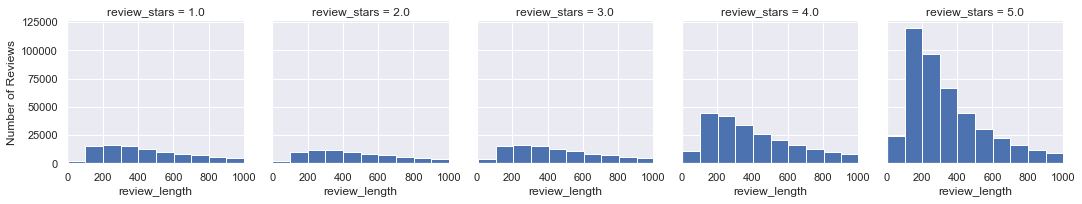

In [47]:
#let's check the distribution of the reviews by length of comments
ax = sns.FacetGrid(data=review_file, col='review_stars', xlim=(0, 1000)).map(plt.hist, 'review_length', bins=50)
ax.axes[0][0].set(ylabel='Number of Reviews')

In [48]:
p_reviews = review_file.text[review_file.review_stars>3].values
n_reviews = review_file.text[review_file.review_stars<3].values
print('Postive  Reviews: {:,}'.format(len(p_reviews)))
print('Negative Reviews: {:,}'.format(len(n_reviews)))

Postive  Reviews: 736,919
Negative Reviews: 216,632


In [49]:
%%time
#TF-IDF


from sklearn.feature_extraction.text import TfidfVectorizer

# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=None, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=None, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(19)
num_reviews = 20000
random_neg = np.random.choice(n_reviews, size=num_reviews)
random_pos = np.random.choice(p_reviews, size=num_reviews)

#dicty = {'pizzas':'pizza', 'burgers':'burger', 'ordered':'order',
#         'prices':'price', 'topping':'toppings'}
#def replace_words(text, dicty):
#    '''Returns text with word substitutions made according
#       to the passed `dicty` dictionary'''
#    for i,j in dicty.items():
#        text = text.replace(i,j)
#    return text

#random_n = [replace_words(w, dicty) for w in random_neg]
#random_p = [replace_words(w, dicty) for w in random_pos]

# Get the vectors
n_vectors = tfidf_neg.fit_transform(random_neg)
p_vectors = tfidf_pos.fit_transform(random_pos)

Wall time: 8.7 s


In [50]:
%%time
# Store TFIDF vectors in a Pandas DataFrame to investigate further
n_df = pd.DataFrame(n_vectors.todense(), columns=[tfidf_neg.get_feature_names()])
p_df = pd.DataFrame(p_vectors.todense(), columns=[tfidf_pos.get_feature_names()])

# get mean for each column (word): highest means are most important words
col_means_neg = {}
for col in n_df:
    col_means_neg[col] = n_df[col].mean()

col_means_pos = {}
for col in p_df:
    col_means_pos[col] = p_df[col].mean()

Wall time: 17.2 s


In [51]:
no_top_words = 20
print('Top %d words in Positive reviews:' %no_top_words, end='')
print(sorted(col_means_pos, key=col_means_pos.get, reverse=True)[:no_top_words])
print('Top %d words in Negative reviews:' %no_top_words, end='')
print(sorted(col_means_neg, key=col_means_neg.get, reverse=True)[:no_top_words])

Top 20 words in Positive reviews:[('we',), ('great',), ('food',), ('in',), ('this',), ('you',), ('with',), ('good',), ('my',), ('place',), ('had',), ('they',), ('but',), ('are',), ('have',), ('that',), ('on',), ('very',), ('service',), ('so',)]
Top 20 words in Negative reviews:[('we',), ('they',), ('were',), ('on',), ('had',), ('with',), ('you',), ('our',), ('at',), ('have',), ('place',), ('so',), ('service',), ('be',), ('there',), ('good',), ('out',), ('just',), ('no',), ('like',)]


In [52]:
# LSA
from gensim import corpora, models, similarities, matutils

# Convert sparse matrix of counts to a gensim corpus
# Need to transpose it for gensim which wants terms by docs instead of docs by terms
tfidf_pos_corpus = matutils.Sparse2Corpus(p_vectors.transpose())
tfidf_neg_corpus = matutils.Sparse2Corpus(n_vectors.transpose())

# Row indices
id2word_pos = dict((v,k) for k,v in tfidf_pos.vocabulary_.items())
id2word_neg = dict((v,k) for k,v in tfidf_neg.vocabulary_.items())

# This is a hack for Python 3!
id2word_pos = corpora.Dictionary.from_corpus(tfidf_pos_corpus, id2word=id2word_pos)
id2word_neg = corpora.Dictionary.from_corpus(tfidf_neg_corpus, id2word=id2word_neg)

In [53]:
# create LSA model
num_topics = 10
lsi_pos = models.LsiModel(tfidf_pos_corpus, id2word=id2word_pos, num_topics=num_topics)
lsi_neg = models.LsiModel(tfidf_neg_corpus, id2word=id2word_neg, num_topics=num_topics)

In [54]:
topics_to_print = 5

# look at top positive topics
print('Top %d topics for POSITIVE reviews' %(topics_to_print))
print('-'*33)
pprint(lsi_pos.show_topics()[0:topics_to_print])

Top 5 topics for POSITIVE reviews
---------------------------------
[(0,
  '0.207*"we" + 0.167*"in" + 0.159*"you" + 0.159*"this" + 0.156*"food" + '
  '0.155*"great" + 0.152*"with" + 0.149*"my" + 0.143*"good" + 0.142*"they"'),
 (1,
  '0.569*"we" + -0.280*"you" + 0.267*"were" + 0.240*"our" + -0.197*"are" + '
  '0.195*"had" + -0.151*"love" + -0.149*"always" + -0.144*"place" + '
  '0.127*"us"'),
 (2,
  '-0.491*"great" + -0.317*"food" + -0.274*"service" + 0.192*"you" + '
  '0.183*"that" + -0.164*"friendly" + -0.155*"place" + -0.147*"very" + '
  '-0.134*"staff" + -0.133*"atmosphere"'),
 (3,
  '-0.419*"good" + 0.380*"we" + -0.276*"very" + 0.193*"love" + 0.175*"this" + '
  '0.157*"best" + 0.149*"our" + -0.145*"with" + 0.143*"pizza" + '
  '0.143*"always"'),
 (4,
  '-0.884*"pizza" + -0.136*"crust" + -0.126*"good" + 0.120*"food" + '
  '-0.096*"wings" + -0.076*"salad" + -0.068*"cheese" + 0.066*"sushi" + '
  '-0.061*"thin" + -0.059*"sauce"')]


In [55]:
topics_to_print = 5
# look at top negative topics
print('Top %d topics for NEGATIVE reviews' %(topics_to_print))
print('-'*33)
pprint(lsi_neg.show_topics()[0:topics_to_print])

Top 5 topics for NEGATIVE reviews
---------------------------------
[(0,
  '0.293*"we" + 0.160*"they" + 0.155*"our" + 0.151*"were" + 0.137*"had" + '
  '0.133*"on" + 0.130*"with" + 0.128*"you" + 0.128*"at" + 0.123*"have"'),
 (1,
  '-0.558*"we" + -0.336*"our" + -0.219*"us" + 0.211*"you" + -0.138*"she" + '
  '0.128*"they" + 0.123*"place" + -0.119*"minutes" + 0.114*"are" + '
  '-0.105*"were"'),
 (2,
  '-0.263*"we" + -0.246*"were" + 0.221*"she" + 0.208*"me" + 0.199*"you" + '
  '-0.194*"chicken" + 0.166*"order" + -0.154*"very" + 0.151*"he" + '
  '-0.142*"good"'),
 (3,
  '-0.349*"she" + 0.259*"we" + 0.259*"you" + -0.217*"me" + -0.205*"he" + '
  '-0.196*"chicken" + 0.184*"are" + 0.179*"service" + -0.167*"her" + '
  '-0.149*"ordered"'),
 (4,
  '0.845*"pizza" + -0.201*"she" + 0.135*"order" + 0.134*"crust" + -0.100*"her" '
  '+ 0.093*"we" + 0.093*"wings" + 0.083*"they" + 0.081*"minutes" + '
  '0.077*"delivery"')]


In [56]:
%%time
# negative values in LSA topics are annoying
# let's see if we can fix that with NMF
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(p_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(n_vectors)
H_neg = nmf_neg.components_

Wall time: 25.3 s


In [57]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

no_topics = num_topics
no_top_words = 6

print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   2.415*you, 1.038*if, 0.932*they, 0.823*that, 0.802*are, 0.768*can
Topic 1:   2.771*we, 1.161*our, 0.897*were, 0.605*us, 0.577*had, 0.440*back
Topic 2:   2.104*great, 1.400*food, 1.161*service, 0.724*good, 0.697*very, 0.593*friendly
Topic 3:   1.071*with, 0.925*my, 0.842*had, 0.825*good, 0.764*but, 0.646*that
Topic 4:   2.856*pizza, 0.441*crust, 0.304*wings, 0.197*thin, 0.192*good, 0.174*cheese
Topic 5:   1.186*this, 1.118*love, 1.095*place, 0.936*always, 0.801*best, 0.672*been

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   2.342*you, 1.096*are, 0.965*if, 0.948*your, 0.781*they, 0.781*place
Topic 1:   3.219*we, 1.607*our, 1.016*were, 0.950*us, 0.481*table, 0.404*had
Topic 2:   0.828*chicken, 0.750*had, 0.737*were, 0.723*good, 0.723*with, 0.711*very
Topic 3:   1.888*she, 1.287*he, 0.963*her, 0.820*me, 0.750*said, 0.642*asked
Topic 4:   2.762*pizza, 0.450

In [58]:
# look at a random positive and negative reviews
print('Positive Review')
review_num = np.random.randint(0, high=len(random_pos))
print(review_num)
print(random_pos[review_num])

print('\nNegative Review')
review_num = np.random.randint(0, high=len(random_neg))
print(review_num)
print(random_neg[review_num])


Positive Review
3202
This was my favorite restaurant in college. We came here ALL the time. The staff was always friendly, good service, and the sushi is so good and cheap. The tofu steak is great to start with, and if you're going to skip sushi  for your meal, definitely go for the Nabe yaki udon or the miso salmon (both come with a ton of food). ALL of the 101 specials are good options, namely the vegas roll and the krazy maki. And of course sake bombs!! YUM!

Negative Review
8137
Used to love this place about 3-4 years ago.. It was literally my Sunday go to to watch football games and get a bite to eat. I recently went there an apparently the management has changed quite a bit, the food takes forever the wait staff does not seem to care and take forever to get your food order and your drink order. The staff doesn't seem to care and quite honestly I could go anywhere else in Scottsdale and watch the same games and get better service. Definitely not coming back here.


In [59]:
# compute cosine similarities of this review with all other reviews in the new space
import sklearn.metrics.pairwise as smp

cosines = {}
for ind, review in enumerate(W_pos):
    similarity = smp.cosine_similarity(W_pos[review_num].reshape(1,-1), review.reshape(1,-1))
    cosines[ind] = similarity[0][0]

In [60]:
# get top 3 matching reviews
for n in sorted(cosines, key=cosines.get, reverse=True)[1:4]:
    print('-'*50)
    print('>> Similarity {:.3f}'.format(cosines[n]))
    print(random_pos[n])
print('-'*50)

--------------------------------------------------
>> Similarity 0.998
So foxy!! Incredible food!! Great atmosphere! The General Manager Chelsey is incredible and made our party special!! Thank you, thank you, thank you!!  What a great night! Thank you Mr. Fox!! Love it!
--------------------------------------------------
>> Similarity 0.998
Good food! And for dessert, yummy $1 churros!! Fantastic service. The girl at the register is very welcoming and helpful especially if you can't make up your mind (my problem 99.9% of the time) or it's your first time there. I will definitely come back. Don't waste your time at Filiberto's or Federico's, whatever that nasty food is across the street lol happy eating, folks!
--------------------------------------------------
>> Similarity 0.998
Amazing food and Margaritas! You will not be let down, try the puerco en chipotle!
--------------------------------------------------


In [61]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a vectorizer object to generate term document counts
cv_pos = CountVectorizer(stop_words=None, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

cv_neg = CountVectorizer(stop_words=None, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 15000
cv_random_neg = np.random.choice(n_reviews, size=num_reviews)
cv_random_pos = np.random.choice(p_reviews, size=num_reviews)

# replace words from defined dictionary 'dicty'
#cv_random_neg = [replace_words(w, dicty) for w in cv_random_neg]
#cv_random_pos = [replace_words(w, dicty) for w in cv_random_pos]

# Get the cv vectors
cv_neg_vectors = cv_neg.fit_transform(cv_random_neg).transpose()
cv_pos_vectors = cv_pos.fit_transform(cv_random_pos).transpose()

In [62]:
# Convert sparse matrix of counts to a gensim corpus
corpus_neg = matutils.Sparse2Corpus(cv_neg_vectors)
corpus_pos = matutils.Sparse2Corpus(cv_pos_vectors)

# save a mapping (dict) of row id to word (token) for later use by gensim 
id2word_cv_pos = dict((v, k) for k, v in cv_pos.vocabulary_.items())
id2word_cv_neg = dict((v, k) for k, v in cv_neg.vocabulary_.items())

In [63]:
print('Postive Reviews:  {:,}'.format(len(p_reviews)))
print('Negative Reviews:  {:,}'.format(len(n_reviews)))

Postive Reviews:  736,919
Negative Reviews:  216,632


In [64]:
%%time

# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=None, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=None, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# replace words with defined dictionary 'dicty'
#pos_reviews = [replace_words(w, dicty) for w in p_reviews]
#neg_reviews = [replace_words(w, dicty) for w in n_reviews]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(n_reviews)
pos_vectors = tfidf_pos.fit_transform(p_reviews)

Wall time: 3min 1s


In [65]:
%%time
# NMF for all reviews
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

Wall time: 8min 35s


In [66]:
no_topics = num_topics
no_top_words = 6

print('Topics for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTopics for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Topics for POSITIVE reviews
---------------------------------------
Topic 0:   3.130*my, 2.775*that, 2.712*they, 2.657*in, 2.536*have, 2.063*but
Topic 1:   6.192*we, 2.739*our, 2.352*were, 1.575*had, 1.389*us, 1.126*back
Topic 2:   4.813*great, 2.985*food, 2.515*place, 2.373*service, 1.941*this, 1.877*love
Topic 3:   4.552*good, 3.558*very, 1.420*really, 1.359*nice, 1.269*food, 1.117*chicken
Topic 4:   6.939*pizza, 1.231*crust, 0.840*wings, 0.615*thin, 0.581*best, 0.410*cheese
Topic 5:   7.063*you, 2.845*if, 1.930*your, 1.851*are, 1.800*can, 1.495*get

Topics for NEGATIVE reviews
---------------------------------------
Topic 0:   3.785*you, 2.591*they, 1.926*are, 1.611*if, 1.525*your, 1.469*have
Topic 1:   5.788*we, 2.762*our, 1.813*were, 1.735*us, 0.861*table, 0.699*had
Topic 2:   1.536*chicken, 1.343*had, 1.312*good, 1.310*were, 1.256*with, 1.250*very
Topic 3:   3.213*she, 2.026*he, 1.680*her, 1.651*me, 1.307*said, 1.112*asked
Topic 4:   4.990*pizza, 0.751*crust, 0.521*wings, 0.492*c

In [67]:
# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'time/order/service', 1:'service/atmosphere', 2:'service/pizza', 
              3:'serivce/atmosphere/staff', 4:'friendly_staff', 5:'bar/happy_hour'}

neg_topics = {0:'beer/people', 1:'food/chicken/salad', 2:'food/pizza', 
              3:'wait/table', 4:'order/time/location', 5:'bad_service'}

In [68]:
#  positive & negative reviews that we can that topics information will be added to
df_pos = review_file[['business_id', 'review_stars', 'text', 'review_length']][review_file.review_stars>3].reset_index()
df_neg = review_file[['business_id', 'review_stars', 'text', 'review_length']][review_file.review_stars<3].reset_index()
df_pos.drop(labels='index', axis=1, inplace=True)
df_neg.drop(labels='index', axis=1, inplace=True)

print('Topic weights : ', W_pos[0])
print('Sum of weights: ', W_pos[0].sum())

Topic weights :  [0.00629771 0.00379649 0.01503868 0.00722597 0.         0.        ]
Sum of weights:  0.03235885209340315


In [69]:
from sklearn.preprocessing import normalize
print('Normalized Topic weights : ', normalize(W_pos[0].reshape(1,-1), norm='l1'))
print('Sum of normalized weights: ', normalize(W_pos[0].reshape(1,-1), norm='l1').sum())

Normalized Topic weights :  [[0.1946208  0.11732475 0.46474706 0.22330739 0.         0.        ]]
Sum of normalized weights:  0.9999999999999999


In [70]:
# add normalized topic weights to each review
df_pos = pd.concat([df_pos, pd.DataFrame(normalize(W_pos, norm='l1'))], axis=1)
df_neg = pd.concat([df_neg, pd.DataFrame(normalize(W_neg, norm='l1'))], axis=1)

df_neg.head()

,business_id,review_stars,text,review_length,0,1,2,3,4,5
0,44YFU284Z3KDEy25QyVoUw,2.0,This 2 star rating is for the service. Althoug...,518,0.000000,0.543880,0.066061,0.217339,0.000000,0.172720
1,44YFU284Z3KDEy25QyVoUw,2.0,After reading many decent reviews and seeing h...,258,0.176445,0.039820,0.412911,0.139926,0.003718,0.227182
2,44YFU284Z3KDEy25QyVoUw,1.0,The service to grab a seat is slow like 20 min...,366,0.312886,0.143930,0.000000,0.266209,0.000000,0.276974
3,44YFU284Z3KDEy25QyVoUw,2.0,Very disappointed with the lack of flavor in t...,195,0.000000,0.000000,0.852858,0.060020,0.000000,0.087122
4,44YFU284Z3KDEy25QyVoUw,1.0,The wait staff is as nasty as the food. RUDE A...,448,0.631736,0.114449,0.150361,0.000000,0.000000,0.103454


In [71]:

# group by business_id and apply mean/count functions to columns
df_pos_bsns = df_pos.groupby('business_id').agg({'review_stars':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()
df_neg_bsns = df_neg.groupby('business_id').agg({'review_stars':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()

In [72]:
df_pos_bsns.head(5)

,business_id,review_stars,text,review_length,0,1,2,3,4,5
0,-01XupAWZEXbdNbxNg5mEg,4.488889,45,593.666667,0.227136,0.201473,0.211790,0.174414,0.030604,0.154583
1,-050d_XIor1NpCuWkbIVaQ,4.545120,543,766.480663,0.348433,0.160598,0.127937,0.146061,0.010246,0.206724
2,-092wE7j5HZOogMLAh40zA,4.600000,55,539.727273,0.295808,0.125257,0.226929,0.257259,0.011907,0.082841
3,-0WegMt6Cy966qlDKhu6jA,4.307692,13,467.769231,0.251562,0.299137,0.133146,0.171136,0.007924,0.137095
4,-0tgMGl7D9B10YjSN2ujLA,4.421053,76,399.671053,0.265265,0.110565,0.329382,0.145635,0.013224,0.135929


In [73]:
df_neg_bsns.head()

,business_id,review_stars,text,review_length,0,1,2,3,4,5
0,-01XupAWZEXbdNbxNg5mEg,1.421053,38,601.789474,0.260553,0.109799,0.238994,0.116394,0.028686,0.245573
1,-050d_XIor1NpCuWkbIVaQ,1.607143,84,922.940476,0.317048,0.105266,0.287500,0.109508,0.008418,0.172260
2,-092wE7j5HZOogMLAh40zA,1.294118,34,630.970588,0.107109,0.097112,0.483962,0.112511,0.021312,0.177993
3,-0WegMt6Cy966qlDKhu6jA,1.357143,70,639.171429,0.245293,0.214205,0.124553,0.095278,0.009477,0.311194
4,-0tgMGl7D9B10YjSN2ujLA,1.416667,36,541.527778,0.227927,0.129802,0.152092,0.199123,0.006119,0.284937


In [74]:
# we can read in business info from a saved CSV file and add that to our last dataframe

az_df = pd.read_csv('processed_data/restaurants_az.csv')
az_df.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [75]:
# merge business name/city with topic data
df_pos_tot = df_pos_bsns.merge(az_df[['business_id', 'name', 'city', 'stars']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city', 'stars', 0, 1, 2, 3, 4, 5]]

df_neg_tot = df_neg_bsns.merge(az_df[['business_id', 'name', 'city', 'stars']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city', 'stars', 0, 1, 2, 3, 4, 5]]


df_pos_tot.head()

,business_id,name,city,stars,0,1,2,3,4,5
0,-01XupAWZEXbdNbxNg5mEg,18 Degrees,Scottsdale,3.0,0.227136,0.201473,0.211790,0.174414,0.030604,0.154583
1,-050d_XIor1NpCuWkbIVaQ,Matt's Big Breakfast,Phoenix,4.0,0.348433,0.160598,0.127937,0.146061,0.010246,0.206724
2,-092wE7j5HZOogMLAh40zA,Wong's Jr,Peoria,3.0,0.295808,0.125257,0.226929,0.257259,0.011907,0.082841
3,-0WegMt6Cy966qlDKhu6jA,Game Seven Grill,Phoenix,2.0,0.251562,0.299137,0.133146,0.171136,0.007924,0.137095
4,-0tgMGl7D9B10YjSN2ujLA,Dubliner,Phoenix,3.5,0.265265,0.110565,0.329382,0.145635,0.013224,0.135929


In [76]:
scores = df_pos_bsns[df_pos_bsns.business_id == '-0tgMGl7D9B10YjSN2ujLA'].iloc[:,-6:].values
print(az_df[az_df.business_id == '-0tgMGl7D9B10YjSN2ujLA']['name'].values[0] + ' - Positive Reviews')
print('-'*36)
for n in pos_topics:
    print('Topic {}: {:18} > {:.4f}'.format(n, pos_topics[n], scores[0][n]))

Dubliner - Positive Reviews
------------------------------------
Topic 0: time/order/service > 0.2653
Topic 1: service/atmosphere > 0.1106
Topic 2: service/pizza      > 0.3294
Topic 3: serivce/atmosphere/staff > 0.1456
Topic 4: friendly_staff     > 0.0132
Topic 5: bar/happy_hour     > 0.1359


In [77]:
%%time

# write to output CSV
df_pos_tot.to_csv('processed_data/pos_bsns.csv')
df_neg_tot.to_csv('processed_data/neg_bsns.csv')
df_pos.to_csv('processed_data/positive_reviews.csv')
df_neg.to_csv('processed_data/negative_reviews.csv')

Wall time: 28.7 s
